## Ejercicio 1: Ciclo de Rankine Ideal
Un ciclo de Rankine ideal trabaja con vapor de agua. El vapor entra a la turbina saturado y a una
presión de 8 MPa. El vapor entra al condensador a una presión de 0.008 MPa, y sale hacia la bomba
como líquido saturado. El trabajo neto del ciclo es de 100 MW. Se pide:

1. Cálculo de todos los estados del ciclo
1. El rendimiento térmico en % (ηth)
1. El ratio de trabajo de retorno en % (back work ratio, bwr)
1. El flujo másico de vapor en kg/s (ṁ)
1. Los calores intercambiados en MW (Qin y Qout)
1. Los trabajos de la turbina y la bomba en MW (Wp y Wt)
1. Dibujo del ciclo de vapor

In [2]:
# Importamos las librerías que vamos a usar
from seuif97 import *
import seuif97 as sf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [18]:
def plot_water_curve():
    Tc = 647.096 - 273.15  #Temperatura del punto crítico [ºC]
    fig, ax = plt.subplots(1, 1, figsize=(10.0, 5.0))
    # Líneas de líquido y vapor saturado
    npt = np.linspace(10, Tc, 200)
    svap = [s for s in [tx2s(t, 1) for t in npt]]
    sliq = [s for s in [tx2s(t, 0) for t in npt]]
    ax.plot(svap, npt, 'r-', label='Curva de vapor saturado')
    ax.plot(sliq, npt, 'b-', label='Curva de líquido saturado')
    return fig, ax, Tc

(<Figure size 1000x500 with 1 Axes>, <AxesSubplot: >, 373.946)

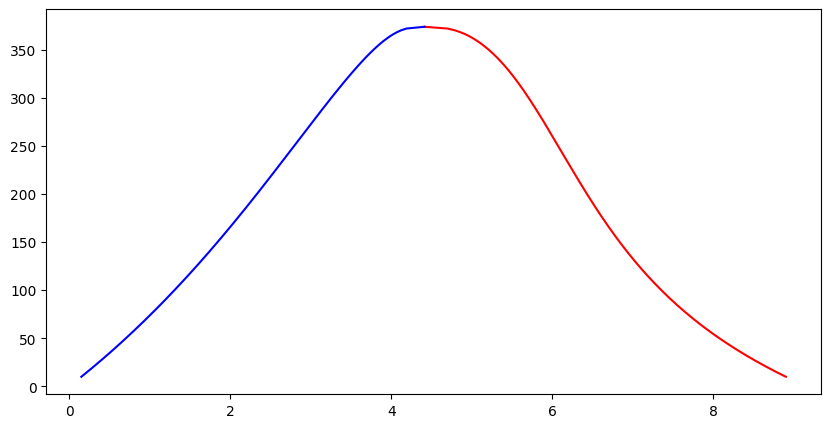

In [19]:
plot_water_curve()

Primero, definimos la clase "State" para los estados que nos va a ayudar a resolver los apartados del ejercicio

In [3]:
class State(object):  #todas las clases tienen la función init, se usa el double underscore para funciones ya asignadas
    def __init__(self, number='', description='', **kwargs):  #key word arguments
        self.number = number
        self.description = description
        self.kwargs = kwargs
        self.all_keys = ('t', 'p', 's', 'h', 'x')  #todos los valores termodinámicos que se van a calcular
        for kwarg, val in kwargs.items():
            setattr(self, kwarg,
                    val)  #es lo mismo que hacer self.t = 480, es decir, se asignan los valores a los argumentos
        self.set_properties()
        #llamaremos a esta clase para definir complemtamento los estados en todos los ciclos, calculando todos los valores
        #termodinámicos en la función calcular_propiedades()

    def __repr__(self):  #self hay que pasarlo siempre
        #En el caso de que queramos saber la información sobre uno o varios estados en concreto, podemos pedir 
        #que se imprima y aparecerá el estado con toda la información siguiente:
        return f'Estado {self.number} - {self.description}: P = {self.p:.4f} MPa, T = {self.t:.2f} ºC, 'f'x = {self.x:.2f} p.u., h = {self.h:.2f} kJ/kg, s = {self.s:.2f} kJ/kgK'  #:.2f es para indicar 2 decimales

    def set_properties(self):
        keys = [k for k in self.kwargs.keys()]  #los valores conocidos que introducimos
        #keys = list(self.kwargs.keys()) sería lo mismo
        unknown_keys = list(set(self.all_keys).difference(
            keys))  #los valores desconocidos son la diferencia entre todos y los conocidos
        function = ''.join(
            keys)  #esto es para unir los input y formar el nombre de las funciones para calcular los demas valores
        #values = [v for v in self.kwargs.values()] ##los diccionarios no están ordenados
        values = [getattr(self, k) for k in keys]
        for var in unknown_keys:
            try:
                setattr(self, var, getattr(sf, f'{function}2{var}')(*values))  #f'' hace lo mismo que ''.format()
                #aplicamos el cálculo explicado previamente, puede ser que dé error porque seuif requiere escribir
                #la fórmula en un orden concreto, si este fuera el caso les damos la vuelta:
            except AttributeError as e:
                setattr(self, var, getattr(sf, f'{function[::-1]}2{var}')(*values[::-1]))

1. Cálculo de todos los estados del ciclo

In [4]:
# Datos de partida

p1 = 8  # [MPa]
p2 = 0.008
x1 = 1  # vapor saturado en la entrada de la turbina
x3 = 0  # líquido saturado en la entrada de la bomba
w_cycle = 100*1000  # [kW]
eta_T = 0.85  # Rendimiento isoentrópico de la turbina
eta_P = 0.85  # Rendimiento isoentrópico de la bomba

In [14]:
class RankineCycle(object):
    def __init__(self, p1, x1, p2, x3, w_cycle, eta_T,
                 eta_P):  #inicializamos la clase con todos los valores que toma y hacemos que siempre realice todos los cálculos
        self.p1 = p1
        self.x1 = x1
        self.p2 = p2
        self.x3 = x3
        self.w_cycle = w_cycle
        self.eta_T1 = eta_T
        self.eta_P = eta_P
        self.get_calculations()

    def make_states(self):
        #Definimos todos los estados gracias a la clase State
        self.state1 = State(1, 'Entrada turbina', x=self.x1, p=self.p1)
        self.state2ideal = State('2i', 'Salida turbina (ideal)', s=self.state1.s, p=self.p2)
        self.h2r = self.state1.h - self.eta_T1 * (self.state1.h - self.state2ideal.h)
        #utilizamos los rendimientos para calcular los estados reales a partir de los ideales
        self.state2 = State(2, 'Salida turbina (real)', h=self.h2r, p=self.p2)
        self.state3 = State(3, 'Entrada bomba', x=self.x3, t=self.state2.t)
        self.state4ideal = State('4i', 'Salida bomba (ideal)', p=self.p1, s=self.state3.s)
        self.h4r = (self.state4ideal.h - self.state3.h) / self.eta_P + self.state3.h
        self.state4 = State(4, 'Salida bomba (real)', h=self.h4r, p=self.p1)
        self.states_order = [self.state1, self.state2, self.state3, self.state4]
        #Necesitamos solo los estados reales a la hora de pintar el ciclo
        self.all_states = [self.state1, self.state2ideal, self.state2, self.state3, self.state4ideal, self.state4]
        #Necesitamos todos los puntos (ideales y reales) a la hora de mostrar todos los estados y resultados

    #Se utilizan las mismas fórmulas utilizadas en el primer ejercicio, pero ordenadas dentro de la clase del ciclo
    def get_enthalpies(self):
        self.w_T = self.state1.h - self.state2.h
        self.w_P = self.state4.h - self.state3.h
        self.q_in = self.state1.h - self.state4.h
        self.q_out = self.state2.h - self.state3.h

    def get_efficiencies(self):
        self.eta_th = (self.w_T_kw - self.w_P_kw) / self.q_in_kw
        self.bwr = self.w_P_kw / (self.w_T_kw)

    def get_mass_flow(self):
        self.mass_flow = (self.w_cycle) / (self.w_T - self.w_P)

    def get_powers(self):
        self.w_T_kw = self.w_T * self.mass_flow
        self.w_P_kw = self.w_P * self.mass_flow
        self.q_in_kw = self.q_in * self.mass_flow
        self.q_out_kw = self.q_out * self.mass_flow

    def get_calculations(self):
        self.make_states()
        self.get_enthalpies()
        self.get_mass_flow()
        self.get_powers()
        self.get_efficiencies()

    def make_dataframe(self):
        #Nos permite imprimir un pandas dataframe para imprimir los resultados de una forma más atractiva que solicitando cada estado
        estadosr = {'Presión [MPa]': [self.all_states[k].p for k in range(len(self.all_states))],
                    'Temperatura [ºC]': [self.all_states[k].t for k in range(len(self.all_states))],
                    'Entalpía [kJ/kg]': [self.all_states[k].h for k in range(len(self.all_states))],
                    'Entropía [kJ/kgK]': [self.all_states[k].s for k in range(len(self.all_states))],
                    'Calidad': [self.all_states[k].x for k in range(len(self.all_states))]}
        df = pd.DataFrame(estadosr)
        df.index = ['Estado 1', 'Estado 2 reversible', 'Estado 2 irreversible', 'Estado 3', 'Estado 4 reversible',
                    'Estado 4 irreversible']
        print('Apartado A)\n')
        return df

    def show_results(self):
        print(f'Apartado B)\n El rendimiento térmico es: eta = {self.eta_th:.3f}.')
        print(f'Apartado C)\n El back work ratio es: bwr = {self.bwr:.3f}.')
        print(f'Apartado D)\n El flujo de masa es: m_dot = {self.mass_flow:.3f} kg/s.')
        #         print(
        #             f'El calor introducido por la caldera es Qin = {self.q_in:.2f} KJ/kg, Qout = {self.q_out:.2f}  KJ/kg, Wt1 = {self.w_t1:.2f} KJ/kg, '
        #             f'Wt2 = {self.w_t2:.2f} KJ/kg, Wp = {self.w_p:.2f} KJ/kg')
        print(
            f'Apartado E)\n El calor introducido por la caldera es: Qin = {self.q_in_kw:.2f} kW,\n el extraído por el condensador es: Qout = {self.q_out_kw:.2f} kW.')
        print(
            f'Apartado F)\n El trabajo de la turbina es Wt = {self.w_T_kw:.2f} kW,\n y el trabajo de la bomba es: Wp = {self.w_P_kw:.2f} kW.')

    def plot_water_curve(self):
        Tc = 647.096 - 273.15  #Temperatura del punto crítico [ºC]
        fig, ax = plt.subplots(1, 1, figsize=(10.0, 5.0))
        # Líneas de líquido y vapor saturado
        npt = np.linspace(10, Tc, 200)
        svap = [s for s in [tx2s(t, 1) for t in npt]]
        sliq = [s for s in [tx2s(t, 0) for t in npt]]
        ax.plot(svap, npt, 'r-', label='Curva de vapor saturado')
        ax.plot(sliq, npt, 'b-', label='Curva de líquido saturado')
        return fig, ax, Tc

    def plot_cycle(self):
        print('Apartado G)\n')

        # plt.legend(['Curva de vapor saturado', 'Curva de líquido saturado'])
        fig, ax, Tc = self.plot_water_curve()
        t = [self.states_order[k].t for k in range(len(self.states_order))]
        s = [self.states_order[k].s for k in range(len(self.states_order))]
        #Agrupamos todos los valores de temperatura y entropía de los puntos del ciclo real

        # Es necesario añadir el punto de líquido saturado a p1 para definir la curva
        self.estado_a = State('a', p=self.state1.p, x=0)
        t.append(self.estado_a.t)
        s.append(self.estado_a.s)

        # Y finalizamos la curva de nuevo en el punto 1 de partida
        t.append(self.state1.t)
        s.append(self.state1.s)

        ax.plot(s, t, 'ko-')

        #Marcamos el recorrido del turbinado ideal
        tTi = [self.state1.t, self.state2ideal.t]
        sTi = [self.state1.s, self.state2ideal.s]
        ax.plot(sTi, tTi, 'ko--')

        #Marcamos el recorrido del bombeado ideal
        tPi = [self.state3.t, self.state4ideal.t]
        sPi = [self.state3.s, self.state4ideal.s]
        ax.plot(sPi, tPi, 'ko--')

        ax.set_xlabel('Entropía (kJ/(kg K)')
        ax.set_ylabel('Temperatura (°C)')
        ax.annotate('1', xy=[self.state1.s * 1.03, self.state1.t * 1.05])
        ax.annotate('2 real', xy=[self.state2.s * 1.04, self.state2.t * 1.05])
        ax.annotate('2 ideal', xy=[self.state2ideal.s * 0.88, self.state2ideal.t * 1.3])
        ax.annotate('3', xy=[self.state3.s * 1.13, self.state3.t * 0.55])
        ax.annotate('4 ideal\n y real', xy=[self.state4.s * 0.1, self.state4.t * 1.5])
        ax.annotate('Punto crítico', xy=[(tx2s(Tc, 1)) * 0.9, (Tc) * 1.05])
        ax.grid()

In [15]:
ciclo = RankineCycle(p1, x1, p2, x3, w_cycle, eta_T, eta_P)
df = ciclo.make_dataframe()
df

Apartado A)



,Presión [MPa],Temperatura [ºC],Entalpía [kJ/kg],Entropía [kJ/kgK],Calidad
Estado 1,8.000,295.009121,2758.611081,5.744849,1.000000
Estado 2 reversible,0.008,41.510053,1795.077037,5.744849,0.674839
Estado 2 irreversible,0.008,41.510053,1939.607143,6.204171,0.735000
Estado 3,0.008,41.510053,173.851769,0.592532,0.000000
Estado 4 reversible,8.000,41.751969,181.897786,0.592532,0.000000
Estado 4 irreversible,8.000,42.093301,183.317672,0.597038,0.000000


Apartado G)



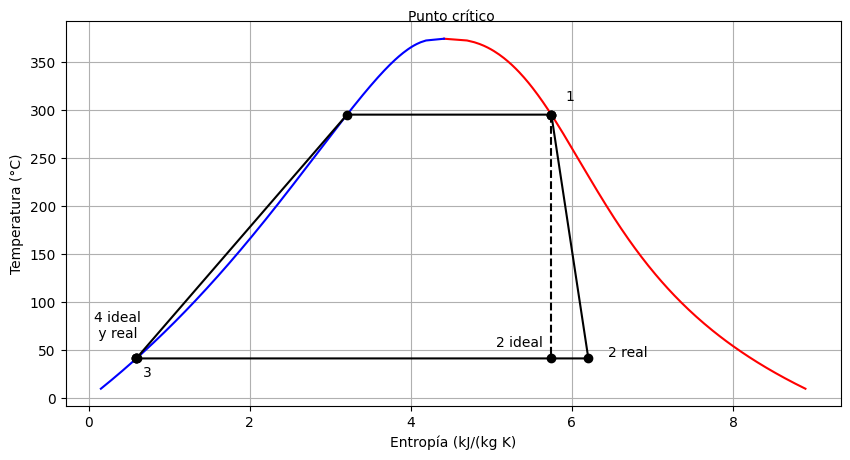

In [16]:
ciclo.plot_cycle()

In [20]:
ciclo.show_results()

Apartado B)
 El rendimiento térmico es: eta = 0.314.
Apartado C)
 El back work ratio es: bwr = 0.012.
Apartado D)
 El flujo de masa es: m_dot = 123.527 kg/s.
Apartado E)
 El calor introducido por la caldera es: Qin = 318118.89 kW,
 el extraído por el condensador es: Qout = 218118.89 kW.
Apartado F)
 El trabajo de la turbina es Wt = 101169.30 kW,
 y el trabajo de la bomba es: Wp = 1169.30 kW.
